In [1]:
import sys
import os

# Add parent directory to Python path
parent_dir = os.path.abspath("/home/e90244aa/Bleep/DeepPathway/")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [2]:
import config as cfg
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import config as cfg
import numpy as np
import torch.nn.functional as F
from numpy.linalg import norm
from scipy import stats
from data_loaders import build_loaders, build_loaders_inference
from models import BLEEPOnly, BLEEPWithOptimus, BLEEP_MLP, DeepPathway
from utils import *
from spatialdata import read_zarr
import scanpy as sc
from visualization import plot_sdata
import math
import os

/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/e9

In [ ]:
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set environment variable for Python hash
torch.use_deterministic_algorithms(True) #newly added line
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8" #newly added line

os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
def train_epoch(model, train_loader, optimizer, lr_scheduler=None):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.cuda(cfg.device) for k, v in batch.items() if k == "image" or k == "reduced_expression" or k =='pos encodings' or k =='st_feat'}
        optimizer.zero_grad()
        loss = model(batch)
        loss.backward()
        optimizer.step()
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def test_epoch(model, test_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(test_loader, total=len(test_loader))
    for batch in tqdm_object:
        batch = {k: v.cuda(cfg.device) for k, v in batch.items() if k == "image" or k == "reduced_expression" or k =='pos encodings' or k =='st_feat'}
        loss = model(batch)
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [5]:
tr_loss = []
tst_loss = []
best_loss = float('inf')
best_epoch = 0

In [6]:
model=BLEEPWithOptimus().to(cfg.device)
print("Model is BLEEP with Optimus using Image Encoder of ResNet18")

Model is BLEEP with Optimus using Image Encoder of ResNet18


In [7]:
print("Finished Loading Model.....:", cfg.method)
train_loader, test_loader=build_loaders(cfg.train_samples,cfg.root_path)
save_path=cfg.root_path + "saved_weights/itr_01" + cfg.method + "_" + cfg.dataset + "_pathways_" + cfg.test_sample + ".pt"
early_stopping=EarlyStopping(patience=cfg.patience, verbose=True,path=save_path)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
print("Training Started of Model",cfg.method)

Finished Loading Model.....: Bleep+optimus
Building loaders
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
12616 3155
train/test split completed
Finished building loaders
Training Started of Model Bleep+optimus


In [8]:
for epoch in range(cfg.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer)
    tr_loss.append(train_loss.avg)

    model.eval()
    with torch.no_grad():
        test_loss = test_epoch(model, test_loader)
        lss = test_loss.avg
        tst_loss.append(lss)

    if lss < best_loss:
        best_loss = lss
        best_epoch = epoch
        print(f"Best loss at Epoch: {epoch + 1}")
        torch.save(model.state_dict(), save_path)
    # Early Stopping Check
    early_stopping(lss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch: 1


100%|██████████████████████████| 50/50 [00:07<00:00,  6.70it/s, valid_loss=6.32]


Best loss at Epoch: 1
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 2


100%|██████████████████████████| 50/50 [00:07<00:00,  6.51it/s, valid_loss=5.72]


Best loss at Epoch: 2
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 3


100%|██████████████████████████| 50/50 [00:07<00:00,  6.50it/s, valid_loss=5.35]


Best loss at Epoch: 3
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 4


100%|██████████████████████████| 50/50 [00:07<00:00,  6.55it/s, valid_loss=5.09]


Best loss at Epoch: 4
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 5


100%|██████████████████████████| 50/50 [00:07<00:00,  6.49it/s, valid_loss=4.88]


Best loss at Epoch: 5
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 6


100%|███████████████████████████| 50/50 [00:07<00:00,  6.53it/s, valid_loss=4.7]


Best loss at Epoch: 6
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 7


100%|██████████████████████████| 50/50 [00:07<00:00,  6.57it/s, valid_loss=4.54]


Best loss at Epoch: 7
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 8


100%|███████████████████████████| 50/50 [00:07<00:00,  6.60it/s, valid_loss=4.4]


Best loss at Epoch: 8
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 9


100%|██████████████████████████| 50/50 [00:07<00:00,  6.53it/s, valid_loss=4.27]


Best loss at Epoch: 9
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 10


100%|██████████████████████████| 50/50 [00:07<00:00,  6.60it/s, valid_loss=4.16]


Best loss at Epoch: 10
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 11


100%|██████████████████████████| 50/50 [00:07<00:00,  6.56it/s, valid_loss=4.06]


Best loss at Epoch: 11
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 12


100%|██████████████████████████| 50/50 [00:07<00:00,  6.52it/s, valid_loss=3.99]


Best loss at Epoch: 12
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 13


100%|██████████████████████████| 50/50 [00:07<00:00,  6.49it/s, valid_loss=3.91]


Best loss at Epoch: 13
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 14


100%|██████████████████████████| 50/50 [00:07<00:00,  6.54it/s, valid_loss=3.85]


Best loss at Epoch: 14
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 15


100%|██████████████████████████| 50/50 [00:07<00:00,  6.55it/s, valid_loss=3.79]


Best loss at Epoch: 15
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 16


100%|██████████████████████████| 50/50 [00:07<00:00,  6.52it/s, valid_loss=3.74]


Best loss at Epoch: 16
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 17


100%|██████████████████████████| 50/50 [00:07<00:00,  6.52it/s, valid_loss=3.71]


Best loss at Epoch: 17
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 18


100%|██████████████████████████| 50/50 [00:07<00:00,  6.64it/s, valid_loss=3.67]


Best loss at Epoch: 18
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 19


100%|██████████████████████████| 50/50 [00:07<00:00,  6.56it/s, valid_loss=3.63]


Best loss at Epoch: 19
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 20


100%|██████████████████████████| 50/50 [00:07<00:00,  6.29it/s, valid_loss=3.61]


Best loss at Epoch: 20
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 21


100%|███████████████████████████| 50/50 [00:07<00:00,  6.53it/s, valid_loss=3.6]


Best loss at Epoch: 21
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 22


100%|██████████████████████████| 50/50 [00:07<00:00,  6.57it/s, valid_loss=3.58]


Best loss at Epoch: 22
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 23


100%|██████████████████████████| 50/50 [00:07<00:00,  6.57it/s, valid_loss=3.55]


Best loss at Epoch: 23
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 24


100%|██████████████████████████| 50/50 [00:07<00:00,  6.52it/s, valid_loss=3.55]


Best loss at Epoch: 24
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 25


100%|██████████████████████████| 50/50 [00:07<00:00,  6.57it/s, valid_loss=3.54]


Best loss at Epoch: 25
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 26


100%|██████████████████████████| 50/50 [00:07<00:00,  6.31it/s, valid_loss=3.53]


Best loss at Epoch: 26
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 27


100%|██████████████████████████| 50/50 [00:07<00:00,  6.54it/s, valid_loss=3.49]


Best loss at Epoch: 27
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 28


100%|██████████████████████████| 50/50 [00:07<00:00,  6.59it/s, valid_loss=3.52]


EarlyStopping counter: 1 out of 5
Epoch: 29


100%|██████████████████████████| 50/50 [00:07<00:00,  6.58it/s, valid_loss=3.47]


Best loss at Epoch: 29
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 30


100%|██████████████████████████| 50/50 [00:07<00:00,  6.59it/s, valid_loss=3.46]


Best loss at Epoch: 30
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 31


100%|██████████████████████████| 50/50 [00:07<00:00,  6.56it/s, valid_loss=3.47]


EarlyStopping counter: 1 out of 5
Epoch: 32


100%|██████████████████████████| 50/50 [00:07<00:00,  6.43it/s, valid_loss=3.43]


Best loss at Epoch: 32
Validation loss decreased. Saving model to prostate cancer dataset/saved_weights/itr_01Bleep+optimus_prostate_pathways_MEND161.pt
Epoch: 33


100%|██████████████████████████| 50/50 [00:07<00:00,  6.38it/s, valid_loss=3.46]


EarlyStopping counter: 1 out of 5
Epoch: 34


100%|██████████████████████████| 50/50 [00:07<00:00,  6.53it/s, valid_loss=3.45]


EarlyStopping counter: 2 out of 5
Epoch: 35


100%|███████████████████████████| 50/50 [00:07<00:00,  6.58it/s, valid_loss=3.5]


EarlyStopping counter: 3 out of 5
Epoch: 36


100%|██████████████████████████| 50/50 [00:07<00:00,  6.58it/s, valid_loss=3.45]


EarlyStopping counter: 4 out of 5
Epoch: 37


100%|██████████████████████████| 50/50 [00:07<00:00,  6.57it/s, valid_loss=3.55]

EarlyStopping counter: 5 out of 5
Early stopping


# Testing

In [4]:
def get_predictions(test_loader,model_path, model,model_tag=None):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    print("Finished loading model")

    test_image_embeddings = []
    test_expression_embeddings = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch["image"].cuda()
            optim_feat = batch['st_feat'].cuda()
            expression = batch['reduced_expression'].cuda()
            if model_tag=="BLEEPOnly":
                image_features = model.image_encoder(images)
                image_embeddings=model.image_projection(image_features)
                expression_embedding = model.spot_projection(expression)
            elif model_tag=="BLEEPWithOptimus":
                image_features = model.image_encoder(images)
                image_features = torch.cat((image_features, optim_feat), dim=1)
                image_embeddings=model.image_projection(image_features)
                expression_embedding = model.spot_projection(expression)
            elif model_tag=="DeepPathway":
                image_features = model.image_model.image_encoder(images)
                image_features = torch.cat((image_features, optim_feat), dim=1)
                image_features = model.image_model.image_projection(image_features)
                image_embeddings = model.img_linear(image_features) # here it is direct prediction
                expression_embedding=expression
            else:
                image_features = model.image_model.image_encoder(images)
                image_embeddings=model.image_model.image_projection(image_features)
                image_embeddings=model.img_linear(image_features)
                expression_embedding=expression   # just to avoid errors, pasted the same GT expression.
            test_image_embeddings.append(image_embeddings)
            test_expression_embeddings.append(expression_embedding)
    return torch.cat(test_image_embeddings), torch.cat(test_expression_embeddings)

def get_weighted_expression(image_query,expression_gt,spot_key,expression_key,method='average',k=10):
    if image_query.shape[1] != 256:
        image_query = image_query.T
        print("image query shape: ", image_query.shape)
    if expression_gt.shape[0] != image_query.shape[0]:
        expression_gt = expression_gt.T
        print("expression_gt shape: ", expression_gt.shape)
    if spot_key.shape[1] != 256:
        spot_key = spot_key.T
        print("spot_key shape: ", spot_key.shape)
    if expression_key.shape[0] != spot_key.shape[0]:
        expression_key = expression_key.T
        print("expression_key shape: ", expression_key.shape)

    if method == "simple":
        indices = find_matches(spot_key, image_query, top_k=k)
        matched_spot_embeddings_pred = spot_key[indices[:, 0], :]
        print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        matched_spot_expression_pred = expression_key[indices[:, 0], :]
        print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    if method == "average":
        print("finding matches, using average of top 10 expressions")
        indices = find_matches(spot_key, image_query, top_k=k)
        matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
        matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
        for i in range(indices.shape[0]):
            # print(i)
            matched_spot_embeddings_pred[i, :] = np.average(spot_key[indices[i, :], :], axis=0)
            matched_spot_expression_pred[i, :] = np.average(expression_key[indices[i, :], :], axis=0)

        print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    if method == "weighted_average":
        print("finding matches, using weighted average of top 50 expressions")
        indices = find_matches(spot_key, image_query, top_k=k)
        matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
        matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
        for i in range(indices.shape[0]):
            a = np.sum((spot_key[indices[i, 0], :] - image_query[i, :]) ** 2)  # the smallest MSE
            weights = np.exp(-(np.sum((spot_key[indices[i, :], :] - image_query[i, :]) ** 2, axis=1) - a + 1))
            if i == 0:
                print("weights: ", weights)
            matched_spot_embeddings_pred[i, :] = np.average(spot_key[indices[i, :], :], axis=0, weights=weights)
            matched_spot_expression_pred[i, :] = np.average(expression_key[indices[i, :], :], axis=0, weights=weights)

        print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
        print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)

    true = expression_gt
    pred = matched_spot_expression_pred
    return pred

def get_predicted_expressions(a,root_path,img_embeddings_all,spot_embeddings_all,k=10):
    data = []
    datasize = []
    for each in a:
        temp = np.array(pd.read_csv(root_path+"pathway expression/"+each+"_pathway expression.csv").iloc[:,1:]).T
        datasize.append(temp.shape[1])
        data.append(temp)
    for i in range(len(a)):
        index_start = sum(datasize[:i])
        index_end = sum(datasize[:i + 1])
        image_embeddings = img_embeddings_all[index_start:index_end]
        spot_embeddings = spot_embeddings_all[index_start:index_end]
        np.save(root_path + "img_embeddings_" + str(i + 1) + ".npy", image_embeddings.T)
        np.save(root_path + "spot_embeddings_" + str(i + 1) + ".npy", spot_embeddings.T)
    expression_key=np.concatenate([data[i] for i in range(1,len(data))],axis=1)
    spot_key=np.concatenate([np.load(root_path+"spot_embeddings_"+str(i+1)+".npy") for i in range(1,len(data))],axis=1)
    image_query = np.load(root_path + "img_embeddings_1.npy")
    expression_gt = data[0].T
    expression_pred = get_weighted_expression(image_query,expression_gt,spot_key,expression_key,method='average',k=10)
    return expression_pred

def find_matches(spot_embeddings, query_embeddings, top_k=1):
    # find the closest matches
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T  # 2277x2265
    print(dot_similarity.shape)
    _, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)

    return indices.cpu().numpy()

def metrics_calculation(true,pred):
    corr_cells = np.zeros(pred.shape[0])
    sp_corr_cells = np.zeros(pred.shape[0])
    cosine_cells = np.zeros(pred.shape[0])
    for i in range(pred.shape[0]):
        corr_cells[i] = np.corrcoef(pred[i, :], true[i, :])[0, 1]
        sp_corr_cells[i] = stats.spearmanr(pred[i, :], true[i, :])[0]
        cosine_cells[i] = np.dot(pred[i, :], true[i, :]) / (norm(pred[i, :]) * norm(true[i, :]))

    corr_cells = corr_cells[~np.isnan(corr_cells)]
    sp_corr_cells = sp_corr_cells[~np.isnan(sp_corr_cells)]
    cosine_cells = cosine_cells[~np.isnan(cosine_cells)]

    print("Mean Pearson correlation across All spots (pathwaywuse correlation): ", np.mean(corr_cells))
    print("Mean Spearman correlation across spots: ", np.mean(sp_corr_cells))
    print("Mean Cosine Similarity across spots: ", np.mean(cosine_cells))

    corr_pathways = np.zeros(pred.shape[1])
    sp_corr_paths = np.zeros(pred.shape[1])
    cosine_pathways = np.zeros(pred.shape[1])
    for i in range(pred.shape[1]):
        corr_pathways[i] = np.corrcoef(pred[:, i], true[:, i], )[0, 1]
        sp_corr_paths[i] = stats.spearmanr(pred[:, i], true[:, i])[0]
        cosine_pathways[i] = np.dot(pred[:, i], true[:, i]) / (norm(pred[:, i]) * norm(true[:, i]))

    corr_pathways = corr_pathways[~np.isnan(corr_pathways)]
    sp_corr_paths = sp_corr_paths[~np.isnan(sp_corr_paths)]
    cosine_pathways = cosine_pathways[~np.isnan(cosine_pathways)]

    print("Mean Pearson correlation across pathways: ", np.mean(corr_pathways))

    print("Mean Spearman correlation across pathways: ", np.mean(sp_corr_paths))
    print("Mean Cosine Similarity across pathways: ", np.mean(cosine_pathways))
    true_filetered = []
    for k in range(0, corr_pathways.shape[0]):
        if corr_pathways[k] == np.nan:
            continue
        else:
            true_filetered.append(true[:, k])
    true_filetered = np.array(true_filetered).T
    print(true_filetered.shape)
    ind = np.argsort(np.sum(true_filetered, axis=0))[-5:]
    # print("highly expressed indices",ind)
    print("mean Pearson correlation highly expressed pathways: ", np.mean(corr_pathways[ind]))
    # print("mean Spearman correlation highly expressed pathways: ", np.mean(sp_corr_paths[ind]))
    ind = np.argsort(np.var(true_filetered, axis=0))[-5:]
    # print("highly variable indices",ind)
    print("mean Pearson correlation highly variable pathways: ", np.mean(corr_pathways[ind]))
    # print("mean Spearman correlation highly variable pathways: ", np.mean(sp_corr_paths[ind]))
    return

def copy_adata(adata_true,adata_pred):
    adata_pred.obs = adata_true.obs
    adata_pred.uns = adata_true.uns
    adata_pred.var_names = adata_true.var_names
    adata_pred.obsm = adata_true.obsm
    return adata_pred

def contains_nan(sublist):
    return any(isinstance(item, float) and math.isnan(item) for item in sublist)

def get_top_k_pathways(true,pred,pathway_names,k=5):
    res=[]
    top_pathways=[]
    for i in range(0,pred.shape[1]):
        x = np.corrcoef(true[:, i], pred[:, i])[0, 1]
        res.append([i, x])
    cleaned_data = [sublist for sublist in res if not contains_nan(sublist)]
    sorted_data = sorted(cleaned_data, key=lambda x: x[1], reverse=True)
    for i in range(0,k):
        top_pathways.append(pathway_names[sorted_data[i][0]])
    return top_pathways


In [5]:
cfg.test_sample

'MEND154'

In [6]:
print(cfg.root_path  + "itr_01_" + cfg.method + "_" + cfg.dataset + "_pathways_" + cfg.test_sample + ".pt")

/home/e90244aa/Bleep/DeepPathwayV2/prostate cancer dataset/itr_01_DeepPathway_prostate_pathways_MEND154.pt


## Using BLEEP+Optimus

Building loaders
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished building inference loaders
Finished loading model


100%|███████████████████████████████████████████| 75/75 [00:43<00:00,  1.74it/s]


image query shape:  (2546, 256)
spot_key shape:  (16419, 256)
expression_key shape:  (16419, 47)
finding matches, using average of top 10 expressions
torch.Size([2546, 16419])
matched spot embeddings pred shape:  (2546, 256)
matched spot expression pred shape:  (2546, 47)
Mean Pearson correlation across All spots (pathwaywuse correlation):  0.6418895296194997
Mean Spearman correlation across spots:  0.6097861716382801
Mean Cosine Similarity across spots:  0.9673386512877976
Mean Pearson correlation across pathways:  0.18149508998370276
Mean Spearman correlation across pathways:  0.1804258102283013
Mean Cosine Similarity across pathways:  0.9611844837635597
(2546, 47)
mean Pearson correlation highly expressed pathways:  0.1631613384513791
mean Pearson correlation highly variable pathways:  0.20032227107044748
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
AnnData object with n_obs × n_vars = 2546 × 47
    obs: 'in_tiss

/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


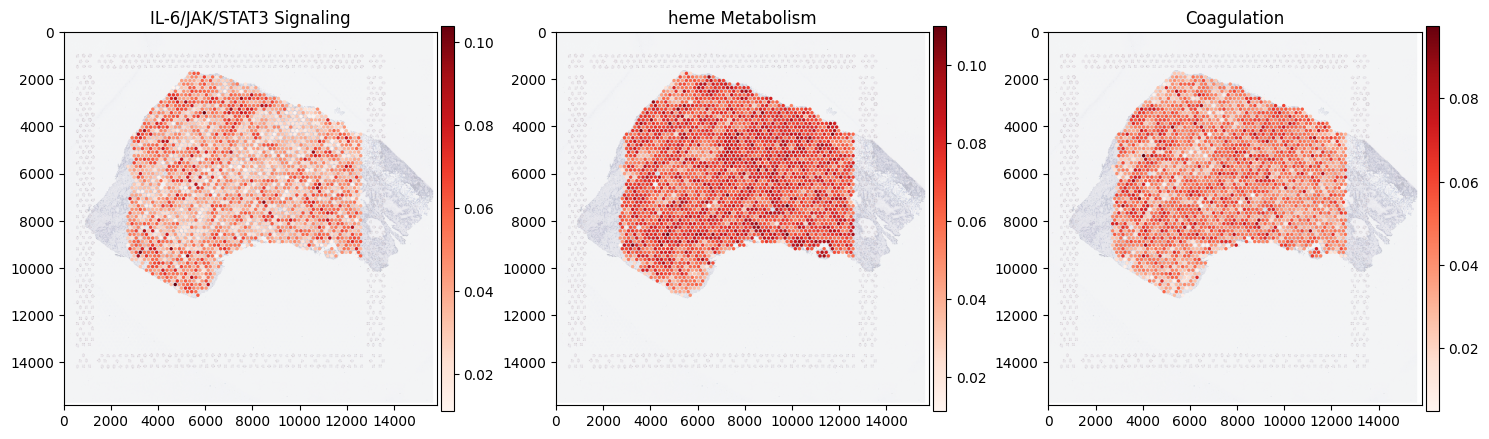

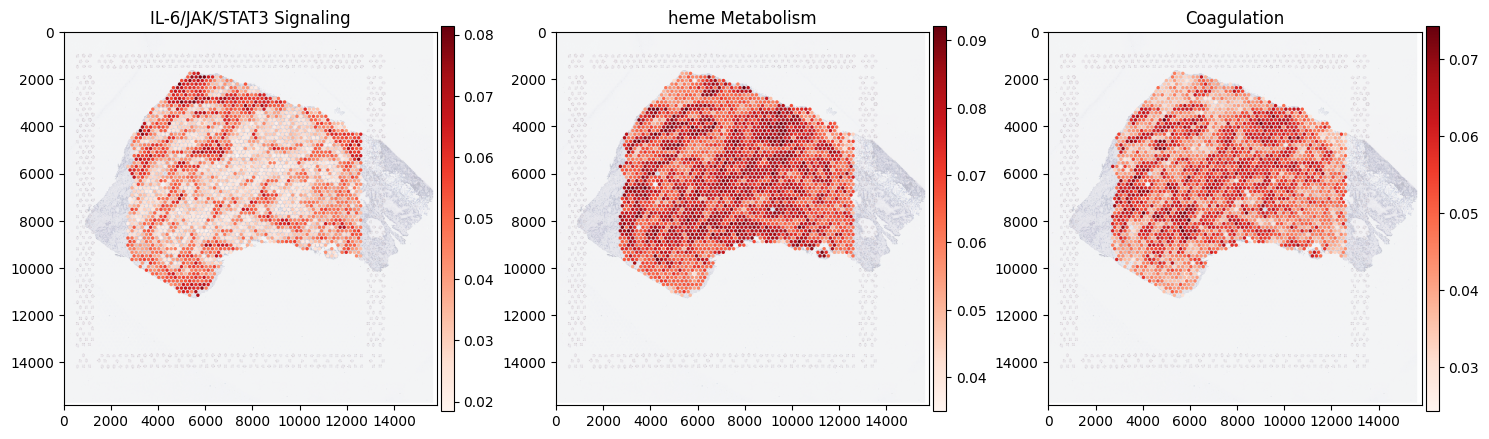

In [6]:
sdata = read_zarr(cfg.root_path+"SpatialData/"+cfg.test_sample+"_spatial_data.zarr")
true=sdata['adata_pathways'].X
data_list = cfg.train_samples
data_list.insert(0, cfg.test_sample)
test_loader = build_loaders_inference(data_list, cfg.root_path)
model_path = cfg.root_path  + "itr_01_" + cfg.method + "_" + cfg.dataset + "_pathways_" + cfg.test_sample + ".pt"
model = BLEEPWithOptimus().to('cuda:0')
image_embeddings_all, spot_embeddings_all = get_predictions(test_loader,model_path, model,model_tag="BLEEPWithOptimus")
image_embeddings_all= image_embeddings_all.cpu().numpy()
spot_embeddings_all  = spot_embeddings_all.cpu().numpy()
pred = get_predicted_expressions(data_list, cfg.root_path, image_embeddings_all, spot_embeddings_all,cfg.top_k)
adata_preds = copy_adata(sdata['adata_pathways'], sc.AnnData(X=pred))
method=str()
if "+" in cfg.method:
    method = cfg.method.replace("+","_")
else:
    method = cfg.method
sdata.tables['predictions_' + method] = adata_preds
# sdata.write(cfg.root_path + "/SpatialData/" + cfg.test_sample + "_spatial_data.zarr", overwrite=True)
metrics_calculation(true,pred)
top_k_pathways = get_top_k_pathways(true, pred, sdata['adata_pathways'].var_names.tolist(), k=3)
plot_sdata(sdata, cfg.test_sample,top_k_pathway_names=top_k_pathways)

## Using DeepPathway

Building loaders
Finished loading all files
Finished building inference loaders
Finished loading model


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Mean Pearson correlation across All spots (pathwaywuse correlation):  0.6583747062189815
Mean Spearman correlation across spots:  0.6131214388327076
Mean Cosine Similarity across spots:  0.96943441959089
Mean Pearson correlation across pathways:  0.08722968251740582
Mean Spearman correlation across pathways:  0.07952614200581999
Mean Cosine Similarity across pathways:  0.960669396064665
(2546, 47)
mean Pearson correlation highly expressed pathways:  0.14762142231134293
mean Pearson correlation highly variable pathways:  0.04423980363264539
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
AnnData object with n_obs × n_vars = 2546 × 47
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'region', 'spot_id'
    uns: 'spatialdata_attrs'
INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_true` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/e90244aa/anaconda3/envs/bleep_env/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata_pred` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


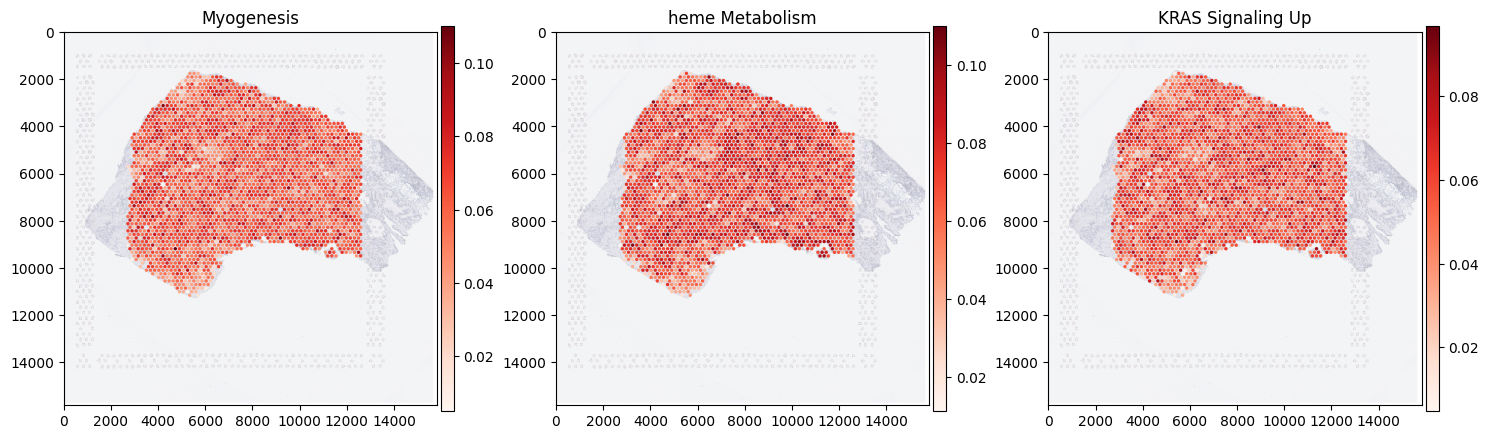

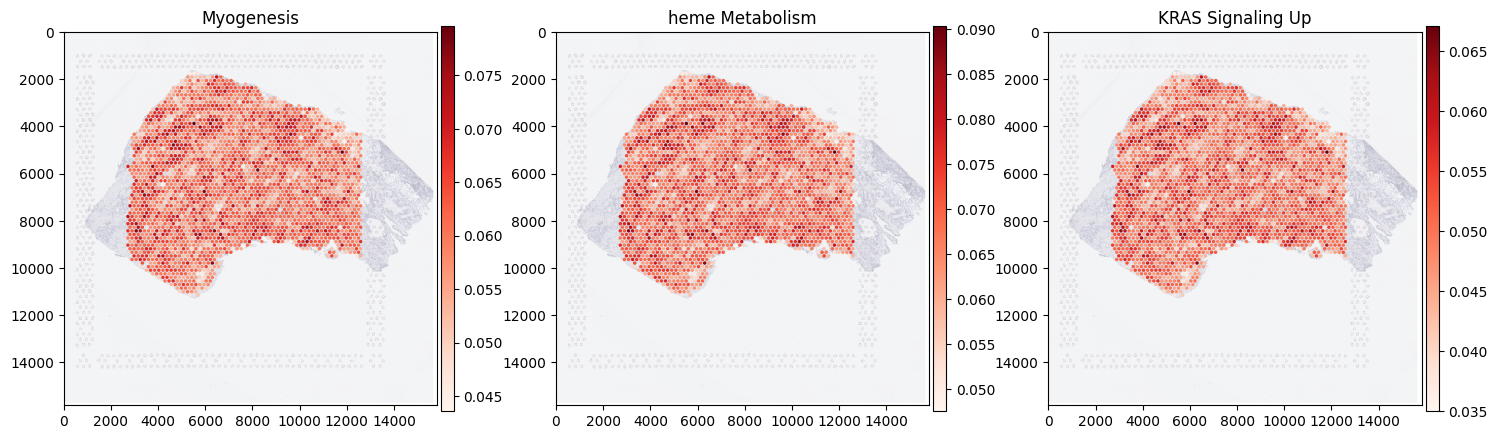

In [8]:
sdata = read_zarr(cfg.root_path+"SpatialData/"+cfg.test_sample+"_spatial_data.zarr")
true=sdata['adata_pathways'].X
test_loader = build_loaders_inference([cfg.test_sample], cfg.root_path)
model_path = cfg.root_path  + "itr_01_" + cfg.method + "_" + cfg.dataset + "_pathways_" + cfg.test_sample + ".pt"
model = DeepPathway().to('cuda:0')
pred, _ = get_predictions(test_loader,model_path, model,model_tag="DeepPathway")
pred  = pred.cpu().numpy()
adata_preds = copy_adata(sdata['adata_pathways'], sc.AnnData(X=pred))
method=str()
if "+" in cfg.method:
    method = cfg.method.replace("+","_")
else:
    method = cfg.method
sdata.tables['predictions_' + method] = adata_preds
# sdata.write(cfg.root_path + "/SpatialData/" + cfg.test_sample + "_spatial_data.zarr", overwrite=True)
metrics_calculation(true,pred)
top_k_pathways = get_top_k_pathways(true, pred, sdata['adata_pathways'].var_names.tolist(), k=3)
plot_sdata(sdata, cfg.test_sample,top_k_pathway_names=top_k_pathways)